In [1]:
""" reference:
    https://qiita.com/MorinibuTakeshi/items/f637e22d5cf216d9974b 
"""

' reference:\n    https://qiita.com/MorinibuTakeshi/items/f637e22d5cf216d9974b \n'

In [ ]:
# import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35,
        rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [5]:
data = pd.read_csv("./data/mastectomy.csv", index_col=0)
data["metastized"] = [1 if k == "yes" else 0 for k in data["metastized"].values]
data.head()

,time,event,metastized
1,23,True,0
2,47,True,0
3,69,True,0
4,70,False,0
5,100,False,0


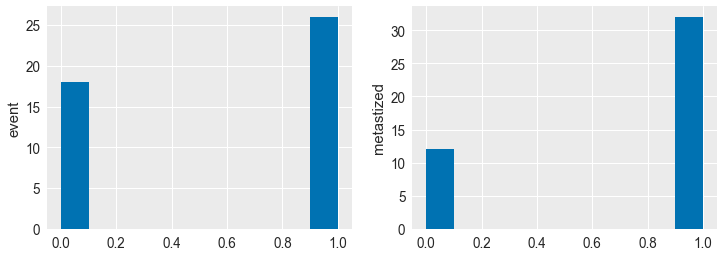

In [9]:
for k, col in enumerate(data.columns[1:]):
    plt.subplot(220 + k + 1)
    plt.hist(data[col])
    plt.ylabel(col);

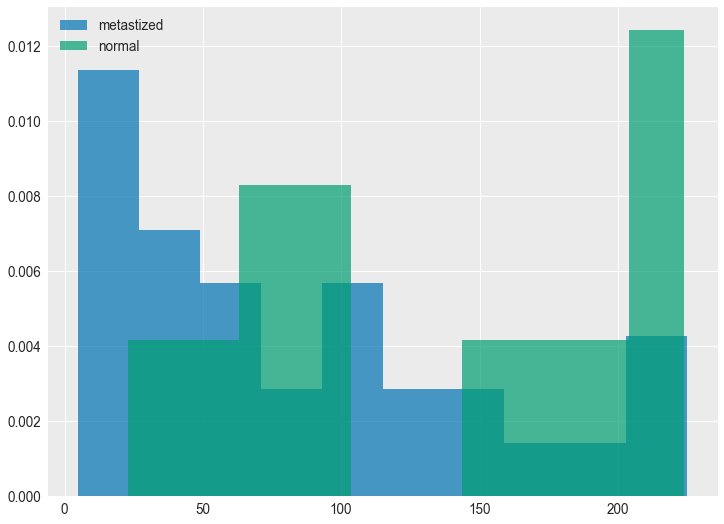

In [12]:
plt.hist(data[data.metastized == 1].time, normed=True, alpha=0.7, label="metastized")
plt.hist(data[data.metastized == 0].time, normed=True, alpha=0.7, label="normal")
plt.legend();

# Do KM

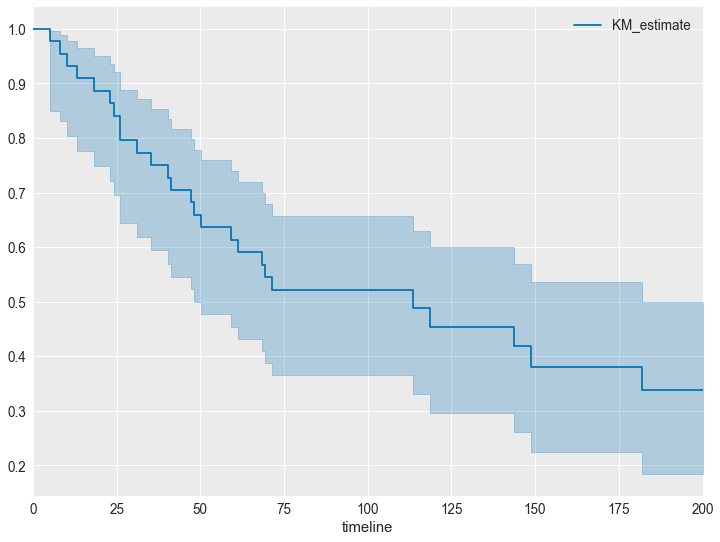

In [14]:
kmf = KaplanMeierFitter()
# first argument: survival time
# second argument: censor info
kmf.fit(data["time"], data["event"], timeline=np.linspace(0,200,200))
kmf.plot();

### Note that KM does not use any covariants, since it is non-parametric.

# Log-rank test (it's also non-parametric)

In [19]:
data_A = data[data.metastized == 1]
data_B = data[data.metastized == 0]

results = logrank_test(data_A.time, data_B.time, data_A.event, data_B.event)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          3.04 0.08      3.62


# Cox proportional hazard model (it's parametric and uses covariants)

<lifelines.CoxPHFitter: fitted with 44 observations, 18 censored>
      duration col = 'time'
         event col = 'event'
number of subjects = 44
  number of events = 26
    log-likelihood = -84.56
  time fit was run = 2019-03-02 12:50:06 UTC

---
            coef  exp(coef)  se(coef)    z    p  -log2(p)  lower 0.95  upper 0.95
metastized  0.85       2.34      0.50 1.70 0.09      3.47       -0.13        1.84
---
Concordance = 0.59
Log-likelihood ratio test = 3.35 on 1 df, -log2(p)=3.90


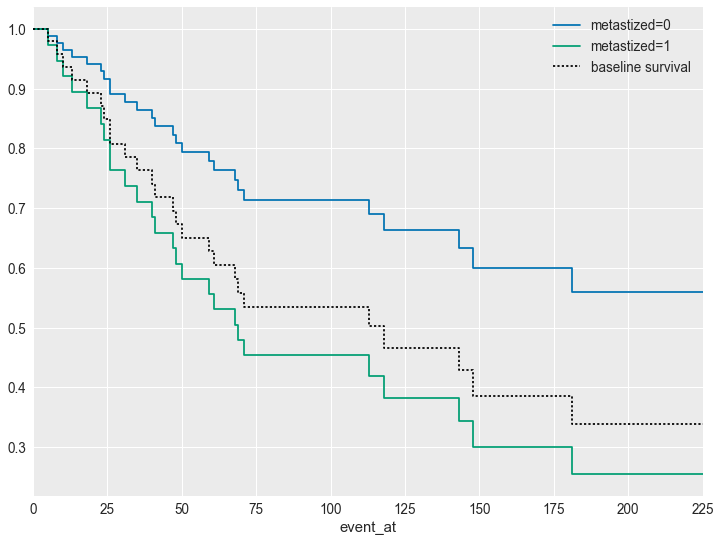

In [22]:
cph = CoxPHFitter()
cph.fit(data, duration_col="time", event_col="event")
cph.print_summary()
cph.plot_covariate_groups("metastized", [0,1]);

# Validate proportional hazard assumption

### log-log plot for each stratum

In [23]:
def verify_proportional_hazard(pre_data, column, col_type="bool"):
    if col_type == "bool":
        pre_data_0 = pre_data[pre_data[column] == 0]
        pre_data_1 = pre_data[pre_data[column] == 1]
    elif col_type == "numerical":
        pre_data_0 = pre_data[pre_data[column] <= pre_data[column].median()]
        pre_data_1 = pre_data[pre_data[column] > pre_data[column].median()]
    else:
        print("col_type Error")
        
    kmf0 = KaplanMeierFitter()
    kmf0.fit(pre_data_0.time, event_observed=pre_data_0.event)
    
    kmf1 = KaplanMeierFitter()
    kmf1.fit(pre_data_1.time, event_observed=pre_data_1.event)
    
    fig, axes = plt.subplots()
    kmf0.plot_loglogs(ax=axes)
    kmf1.plot_loglogs(ax=axes)
    axes.legend(["False", "True"])
    plt.title("Proportional Hazard of " + column)
    plt.show();

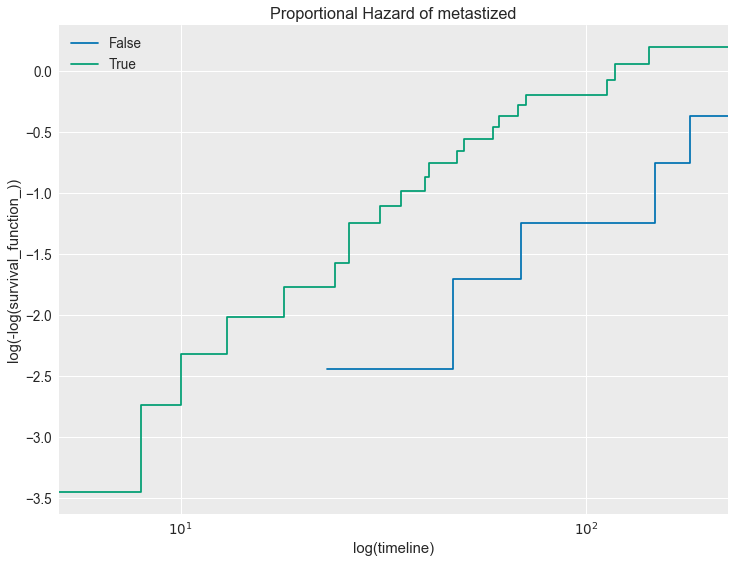

In [24]:
verify_proportional_hazard(data, "metastized")